In [ ]:
cd '/content/drive/MyDrive/maestria/remote_sensing'

/content/drive/MyDrive/maestria/remote_sensing


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import scipy.io
import numpy as np
import pandas as pd

In [ ]:
image_path = 'db_indian_pines/Indian_pines_corrected.mat'
gt_path = 'db_indian_pines/Indian_pines_gt.mat'

img = scipy.io.loadmat(image_path)
img = img['indian_pines_corrected']
labels = scipy.io.loadmat(gt_path)
labels = labels['indian_pines_gt']
#labels = np.reshape(labels,labels.shape[0]*labels.shape[1])

In [ ]:
np.shape(labels)
labels

array([[3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
img_r = np.reshape(img,(img.shape[0]*img.shape[1],img.shape[2]))
labels_r = np.reshape(labels,(labels.shape[0]*labels.shape[1]))

In [ ]:
ind = np.random.randint(0,200,8)
img_r = img_r[:,ind]

In [ ]:
len(img_r)

21025

In [ ]:
img_r.shape

(21025, 8)

In [ ]:
def extract_pixels(X, y):
    q = X.reshape(-1, X.shape[2])
    df = pd.DataFrame(data = q)
    df = pd.concat([df, pd.DataFrame(data = y.ravel())], axis=1)
    df.columns= [f'band{i}' for i in range(1, 1+X.shape[2])]+['class']
    #df.to_csv('Dataset.csv')
    return df

In [ ]:
names = ['Alfalfa','Corn-notill', 'Corn-mintill','Corn','Grass-pasture','Grass-trees',
'Grass-pasture-mowed','Hay-windrowed','Oats','Soybean-notill','Soybean-mintill',
'Soybean-clean', 'Wheat','Woods','Buildings Grass Trees Drives','Stone Steel Towers'] 

In [ ]:
data_indian = extract_pixels(img, labels)
#cleaning data
data_x = data_indian[data_indian['class'] != 0]
img_r = data_x.iloc[:, :-1].values
labels_r = data_x.loc[:, 'class'].values

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(img_r, labels_r, test_size=0.2, random_state=42, stratify = labels_r)
print('Class label counts train:', np.bincount(y_train))
print('Class label counts test:', np.bincount(y_test))

Class label counts train: [   0   37 1142  664  190  386  584   23  382   16  778 1964  474  164
 1012  309   74]
Class label counts test: [  0   9 286 166  47  97 146   5  96   4 194 491 119  41 253  77  19]


In [ ]:
steps = [('scaler',MinMaxScaler()),('classifier',SGDClassifier(max_iter=1000, tol=1e-3))]
pipe = Pipeline(steps)
param_grid = dict(classifier__alpha = [0.01,0.1,1,10,100])

grid_search = GridSearchCV(pipe, param_grid=param_grid)
grid_search.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('classifier', SGDClassifier())]),
             param_grid={'classifier__alpha': [0.01, 0.1, 1, 10, 100]})

In [ ]:
grid_search.best_params_['classifier__alpha']

0.01

In [ ]:
pipe.set_params(classifier__alpha = grid_search.best_params_['classifier__alpha'])

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('classifier', SGDClassifier(alpha=0.01))])

In [ ]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('classifier', SGDClassifier(alpha=0.01))])

In [ ]:
y_est = pipe.predict(X_test)
accuracy_score(y_test,y_est)

0.6063414634146341

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


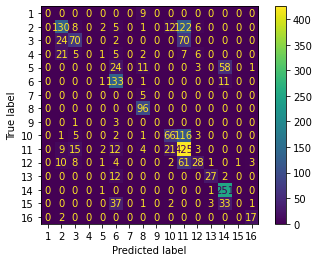

In [ ]:
plot_confusion_matrix(pipe, X_test, y_test) 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
steps = [('scaler',MinMaxScaler()),('classifier',RandomForestClassifier())]
pipe = Pipeline(steps)

n_estimators = [5,20,50,100]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)]
min_samples_split = [2, 6, 10]
min_samples_leaf = [1, 3, 4]
bootstrap = [True, False]

param_grid = dict(classifier__n_estimators = n_estimators,
                  classifier__max_features = max_features,
                  classifier__max_depth = max_depth,
                  classifier__min_samples_split = min_samples_split,
                  classifier__min_samples_leaf = min_samples_leaf,
                  classifier__bootstrap = bootstrap)

grid_search = GridSearchCV(pipe, param_grid=param_grid)
grid_search.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


GridSearchCV(estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid={'classifier__bootstrap': [True, False],
                         'classifier__max_depth': [10, 20, 30, 40, 50, 60, 70,
                                                   80, 90, 100, 110, 120],
                         'classifier__max_features': ['auto', 'sqrt'],
                         'classifier__min_samples_leaf': [1, 3, 4],
                         'classifier__min_samples_split': [2, 6, 10],
                         'classifier__n_estimators': [5, 20, 50, 100]})

In [ ]:
grid_search.best_params_

{'classifier__bootstrap': False,
 'classifier__max_depth': 50,
 'classifier__max_features': 'auto',
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 2,
 'classifier__n_estimators': 100}

In [ ]:
pipe.set_params(classifier__n_estimators = grid_search.best_params_['classifier__n_estimators'])
pipe.set_params(classifier__max_features = grid_search.best_params_['classifier__max_features'])
pipe.set_params(classifier__max_depth = grid_search.best_params_['classifier__max_depth'])
pipe.set_params(classifier__min_samples_split = grid_search.best_params_['classifier__min_samples_split'])
pipe.set_params(classifier__min_samples_leaf = grid_search.best_params_['classifier__min_samples_leaf'])
pipe.set_params(classifier__bootstrap = grid_search.best_params_['classifier__bootstrap'])

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('classifier',
                 RandomForestClassifier(bootstrap=False, max_depth=50))])

In [ ]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('classifier',
                 RandomForestClassifier(bootstrap=False, max_depth=50))])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


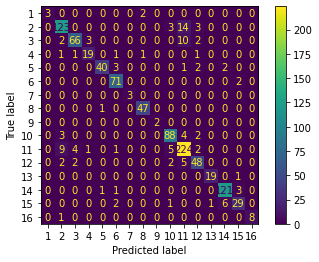

In [ ]:
plot_confusion_matrix(pipe, X_test, y_test) 
#accuracy_score(y_test,y_est)

In [ ]:
y_est = pipe.predict(X_test)
accuracy_score(y_test,y_est)

0.8887804878048781